# Playing with the images of the Protein Altas

## Introduction

In this notebook, several image processing techniques are experimented. 
The objective is just see the result of them when applied to the images of this dataset.

This is largely based on the tutorials of the correspoding python library.

The images are [fluorescence microscope](https://en.wikipedia.org/wiki/Fluorescence_microscope) images with four channels. The protein of interest is visualized in green, while reference markers for microtubules (red),
endoplasmic reticulum (yellow) and nucleus (blue) outline the cell. This is why the images are suffixed the the
color even though they are grayscale PNG images. For more information about the images 
of the Protein Atlas dataset see https://www.proteinatlas.org/humancell/organelle

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.gray()

import skimage.filters

import scipy.ndimage

import sklearn.feature_extraction
import sklearn.cluster

import skimage.feature
import skimage.transform

import PIL

import sys
for name, module in sorted(sys.modules.items()):
    if name in ['numpy', 'matplotlib', 'skimage', 'scipy', 'sklearn', 'PIL']:
        if hasattr(module, '__version__'): 
            print(name, module.__version__)

## Plotting the image with the histogram

The histogram is centered in the mean to be more meaningful.

In [ ]:
def plot_file(filename):
    image = plt.imread(filename)
    hist = np.histogram(image - image.mean(),
                        bins=np.arange(image.min(),
                                       image.max(),
                                       1/256))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image, interpolation='nearest')
    axes[0].axis('off')
    axes[0].set_title(filename[-20:])
    
    axes[1].plot(hist[1][:-1], hist[0], lw=2)
    axes[1].set_title('histogram of gray values')
    
    plt.show()

In [ ]:
plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')
plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

## Cutting

The images are generated by marking the proteins with a fluorescent molecule.
When the pixel have more intensity, then we see that in that point of the image
there are more protein of that kind.

This competition have the target of classify the images by guessing
where is the main occurrence of the protein whose intensity is illustrated by the green image.

The image with uuid '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0' used throughout the notebook is
classified by a human and supported by scientific evidence that the protein marked in the green image 
have the main occurrence in the [Golgi apparatus](https://en.wikipedia.org/wiki/Golgi_apparatus)

As you can see in the plotting above, it occurs in other organelles but there are hot spots around
the nucclei. Maybe we can use some threashold to cut off the noise.

In [ ]:
def plot_cut(uuid, title, threashold_function):
    """Takes an uuid, a title for the plot and a function to apply on the image and obtain a threashold
    and plot the black and white image generated by the binary result of the inequality image > threashold"""
    
    def set_title(title, threashold):
        if np.shape(threashold) != ():
            plt.title('%s threashold=[%s]' % (title, str(np.shape(threashold))))
        else:
            plt.title('%s threashold=%0.3f' % (title, threashold))

    red    = f'../input/train/{uuid}_red.png'
    green  = f'../input/train/{uuid}_green.png'
    blue   = f'../input/train/{uuid}_blue.png'
    yellow = f'../input/train/{uuid}_yellow.png'
    
    fig = plt.figure(figsize=(15, 4))
    fig.suptitle(title, fontsize=24)
    
    plt.subplot(1,4,1)
    image = plt.imread(red)
    threashold = threashold_function(image)
    plt.imshow(image > threashold)
    set_title('red', threashold)

    plt.subplot(1,4,2)
    image = plt.imread(green)
    threashold = threashold_function(image)
    plt.imshow(image > threashold)
    set_title('green', threashold)

    plt.subplot(1,4,3)
    image = plt.imread(blue)
    threashold = threashold_function(image)
    plt.imshow(image > threashold)
    set_title('blue', threashold)

    plt.subplot(1,4,4)
    image = plt.imread(yellow)
    threashold = threashold_function(image)
    plt.imshow(image > threashold)
    set_title('yellow', threashold)

    plt.show()

### Starting with simple threasholds

In [ ]:
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "zero", lambda image: 0)

plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "%5 percentile", lambda image: np.percentile(image, 5))

plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "mean", lambda image: image.mean())

plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "%95 percentile", lambda image: np.percentile(image, 95))

In the plots above, we see that the mean value of intensity is a robust choice to outline locations 
(red, blue and yellow channels). The nucleus is outlined with few artfacts.

To the green channel, the 95% percentile is a better choice. With this threashold
we can see the Golgi apparatus outlined.

### Using skimage.filters thresholds

In [ ]:
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_otsu", skimage.filters.threshold_otsu)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_yen", skimage.filters.threshold_yen)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_isodata", skimage.filters.threshold_isodata)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_li", skimage.filters.threshold_li)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', 
         "skimage.filters.threshold_local(image, block_size=3)", 
         lambda image: skimage.filters.threshold_local(image, block_size=3))
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', 
         "skimage.filters.threshold_local(image, block_size=7)", 
         lambda image: skimage.filters.threshold_local(image, block_size=7))
try:
    plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_minimum", skimage.filters.threshold_minimum)
except:
    pass
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_niblack", skimage.filters.threshold_niblack)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_sauvola", skimage.filters.threshold_sauvola)
plot_cut('002daad6-bbc9-11e8-b2bc-ac1f6b6435d0', "skimage.filters.threshold_triangle", skimage.filters.threshold_triangle)

Each threashold function makes a different black and white representation of the grayscale (intensity level) image.

(Maybe) We can use this as a compressed input (I sweare that I am not doing [early optimization](http://wiki.c2.com/?PrematureOptimization):) or a feature [engeeneared](https://en.wikipedia.org/wiki/Feature_engineering)
with our knowledge of the meaning of the data. What do you think? Comments are welcomed.

## Converting grayscale into a bitmap (boolean array) packet in 64bit words

Take the yellow channel with the Li's threashold

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

cutted = np.array(image > skimage.filters.threshold_li(image))

In [ ]:
cutted.shape, cutted.dtype

In [ ]:
cutted.shape[0] * cutted.shape[1]

We have got 512x512 matrix of boolean values. That is 262144 bits.

In [ ]:
(cutted.shape[0] * cutted.shape[1]) / 8

In [ ]:
(cutted.shape[0] * cutted.shape[1]) / 8 / 8

We can represent this information with 32768 bytes or 4096 [64bit](https://en.wikipedia.org/wiki/64-bit_computing) words.

In [ ]:
packed = np.zeros((int(cutted.shape[0] / 8), int(cutted.shape[1] / 8)),
                  dtype=np.uint64)

for x in range(cutted.shape[0]):
    for y in range(cutted.shape[1]):
        new_bit = np.uint64(int(cutted[x][y]) << (x % 8) << ((y % 8) * 8))
        packed[int(x/8)][int(y/8)] = np.bitwise_or(packed[int(x/8)][int(y/8)], new_bit)

plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.title(f'original {str(image.nbytes)} bytes')
plt.imshow(image)

plt.subplot(1,3,2)
plt.title(f'cutted {str(cutted.nbytes)} bytes')
plt.imshow(cutted)

plt.subplot(1,3,3)
plt.title(f'packed {str(packed.nbytes)} bytes')
plt.imshow(packed)

To show that the information was not lost we can recreate the boolean typed array from the one packed in 64bit integers

In [ ]:
re = np.zeros((cutted.shape[0],cutted.shape[1]), dtype=bool)

for x in range(cutted.shape[0]):
    for y in range(cutted.shape[1]):
        re[x][y] = np.bitwise_and(np.uint64(1 << (x % 8) + (y % 8) * 8 ), packed[int(x/8)][int(y/8)])

plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(image)

plt.subplot(1,3,2)
plt.title('cutted')
plt.imshow(cutted)

plt.subplot(1,3,3)
plt.title('decompressed')
plt.imshow(re)

With this approach, we can have taken an 1 Magabyte image and converted into a meaningful 32 Kilobyte one.

This 64x64 grayscale image below does not looks like the 28x26 images from the [n-mnist](https://www.garrickorchard.com/datasets/n-mnist) dataset:

In [ ]:
plt.imshow(packed)

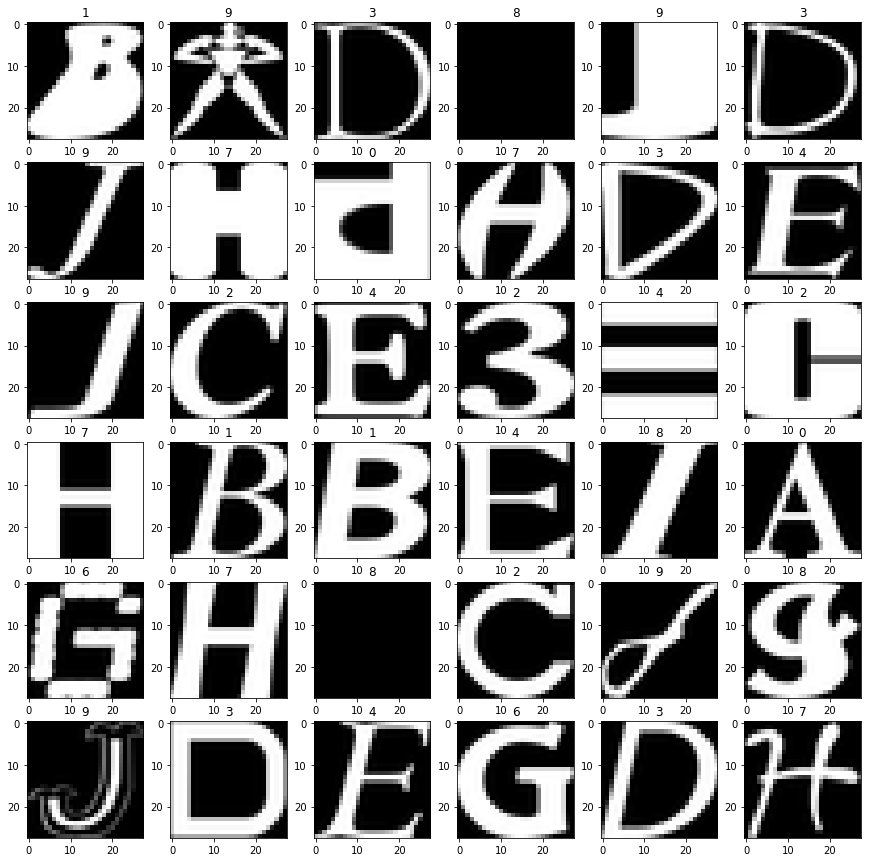

The bitwise operations keeps the information but another options is use simple image reduction that are more efficient.

In [ ]:
def pack_image(cutted):
    packed = np.zeros((int(cutted.shape[0] / 8), int(cutted.shape[1] / 8)),
                      dtype=np.uint64)
    for x in range(cutted.shape[0]):
        for y in range(cutted.shape[1]):
            new_bit = np.uint64(int(cutted[x][y]) << (x % 8) << ((y % 8) * 8))
            packed[int(x/8)][int(y/8)] = np.bitwise_or(packed[int(x/8)][int(y/8)], new_bit)
    return packed
%timeit pack_image(cutted)

In [ ]:
%timeit skimage.transform.resize(cutted, (cutted.shape[0]/8,cutted.shape[1]/8), mode='reflect')

In [ ]:
re = skimage.transform.resize(cutted, (cutted.shape[0]/8,cutted.shape[1]/8), mode='reflect')
plt.imshow(re)

The following is a bit more optimized.

In [ ]:
def pack_image2(img):
    xres, yres = np.shape(img)
    xres = int(xres / 8)
    yres = int(yres / 8)
    p = np.empty((xres,yres))
    for x in range(xres):
        for y in range(yres):
            p[x][y] = int("".join(img[x*8:(x*8)+8,y*8:(y*8)+8].flatten().astype(int).astype(str)), 2)
    return p

%timeit pack_image2(cutted)

## Adding noise to image

In [ ]:
packed.shape, packed.dtype

In [ ]:
packed.flatten().shape

In [ ]:
im_noise = cutted + 0.2 * np.random.randn(*cutted.shape)

In [ ]:
plt.title('cutted with noise')
plt.imshow(im_noise)

In [ ]:
im_noise.dtype

In [ ]:
cutted.dtype

In [ ]:
hist = np.histogram(im_noise - im_noise.mean(),
                    bins=np.arange(im_noise.min(),
                                   im_noise.max(),
                                   1/256))
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('histogram of gray values "cutted with noise" image')

In [ ]:
hist = np.histogram(image - image.mean(),
                    bins=np.arange(image.min(),
                                   image.max(),
                                   1/256))
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('original image histogram of gray values')

## Using scipy.ndimage to remove artifacts

Visual artifacts (also artefacts) are anomalies apparent during visual representation 
as in digital graphics and other forms of imagery, particularly microscopy. 
[1](https://en.wikipedia.org/wiki/Visual_artifact)

We start with the 'cutted' image and try to remove artifacts using the functions
provided by the scipy.ndimage python library.

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('cutted')
plt.imshow(cutted)

plt.subplot(1,3,2)
plt.title('binary_opening(cutted)')
open_img = scipy.ndimage.binary_opening(cutted)
plt.imshow(open_img)

plt.subplot(1,3,3)
plt.title('binary_closing(binary_opening(cutted))')
close_img = scipy.ndimage.binary_closing(open_img)
plt.imshow(close_img)

In [ ]:
eroded_img = scipy.ndimage.binary_erosion(cutted)
reconstruct_img = scipy.ndimage.binary_propagation(eroded_img, mask=cutted)
tmp = np.logical_not(reconstruct_img)
eroded_tmp = scipy.ndimage.binary_erosion(tmp)
reconstruct_final = np.logical_not(scipy.ndimage.binary_propagation(eroded_tmp, mask=tmp))

In [ ]:
plt.imshow(reconstruct_final)

## Using sklearn to do spectral clustering

Well, we know that the 'blue' images are from nucleus and that the 'mean' theashold is the simplest and gives enclosed surfaces. Can we count it?

In [ ]:
%%time
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
cutted = image > image.mean()

graph = sklearn.feature_extraction.image.img_to_graph(image, mask=cutted)
graph.data = np.exp(-graph.data/graph.data.std())

labels = sklearn.cluster.spectral_clustering(graph, n_clusters=20, eigen_solver='arpack')
label_im = -np.ones(cutted.shape)
label_im[cutted] = labels

In [ ]:
plt.imshow(label_im, cmap='nipy_spectral')

Well may be i have used the wrong functions and/or parameters.

## Using scipy.ndimage to do segmentation

(An easier way to count nucleos)

In [ ]:
%%time
label_im, nb_labels = scipy.ndimage.label(image > image.mean())

In [ ]:
plt.imshow(label_im, cmap='nipy_spectral')

In [ ]:
np.unique(label_im).size

Simple, fast and acceptable result..

## Doing granulometry with scipy.ndimage

Optical granulometry is the process of measuring the different grain sizes in a granular material.
[1](https://en.wikipedia.org/wiki/Optical_granulometry)

In [ ]:
def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)

def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes is None:
        sizes = range(1, int(s/2), 2)
    granulo = [scipy.ndimage.binary_opening(data, \
        structure=disk_structure(n)).sum() for n in sizes]
    return granulo

In [ ]:
im = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
mask = im > im.mean()
granulo = granulometry(mask, sizes=np.arange(1, 10, 1))

In [ ]:
granulo

In [ ]:
plt.figure(figsize=(12, 4.4))

plt.subplot(121)
plt.imshow(mask, cmap=plt.cm.gray)
opened = scipy.ndimage.binary_opening(mask, structure=disk_structure(10))
opened_more = scipy.ndimage.binary_opening(mask, structure=disk_structure(14))
plt.contour(opened, [0.5], colors='b', linewidths=1)
plt.contour(opened_more, [0.5], colors='r', linewidths=1)
plt.axis('off')
plt.subplot(122)
plt.plot(np.arange(1, 10, 1), granulo, 'ok', ms=8)

plt.subplots_adjust(wspace=0.02, hspace=0.15, top=0.95, bottom=0.15, left=0, right=0.95)
plt.show()

In [ ]:
def plot_granulos(filename, sizes=np.arange(1, 10, 1)):
    im = plt.imread(filename)
    mask = im > skimage.filters.threshold_li(im)
    granulo = granulometry(mask, sizes=sizes)

    plt.figure(figsize=(12, 4.4))

    plt.subplot(121)
    plt.imshow(mask, cmap=plt.cm.gray)
    opened = scipy.ndimage.binary_opening(mask, structure=disk_structure(1))
    opened_more = scipy.ndimage.binary_opening(mask, structure=disk_structure(4))
    plt.contour(opened, [0.5], colors='b', linewidths=1)
    plt.contour(opened_more, [0.5], colors='r', linewidths=1)
    plt.axis('off')
    plt.subplot(122)
    plt.plot(sizes, granulo, 'ok', ms=8)

    plt.subplots_adjust(wspace=0.02, hspace=0.15, top=0.95, bottom=0.15, left=0, right=0.95)
    plt.show()

In [ ]:
plot_granulos('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
plot_granulos('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')
plot_granulos('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
plot_granulos('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

## Selecting the contour using skimage

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')

s = np.linspace(0, 2*np.pi, 400)
x = 150 + 50*np.cos(s)
y = 150 + 50*np.sin(s)
init = np.array([x, y]).T

filtered = skimage.filters.gaussian(image, 2)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(filtered)

In [ ]:
snake = skimage.segmentation.active_contour(filtered,
                                            init,
                                            alpha=0.002,
                                            beta=10,
                                            gamma=0.01)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, image.shape[1], image.shape[0], 0])

plt.show()

## Doing blob detection with skimage

See https://en.wikipedia.org/wiki/Blob_detection

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')

blobs_log = skimage.feature.blob_log(image, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * (2 ** .5)

blobs_dog = skimage.feature.blob_dog(image, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * (2 ** .5)

blobs_doh = skimage.feature.blob_doh(image, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)

plt.tight_layout()
plt.show()

May be the patterns of the blobs could be used as a feature

## Canny edge detector with skimage.feature

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. [1](https://en.wikipedia.org/wiki/Canny_edge_detector)

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
edges = skimage.feature.canny(image)

plt.imshow(edges)
plt.title('Canny detector');

In [ ]:
fill_image = scipy.ndimage.binary_fill_holes(edges)

plt.imshow(fill_image)
plt.title('filling the holes');

## Color visualization of the Protein Atlas images

In [ ]:
red    = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
green  = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')
blue   = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
yellow = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

### A first approach for creating an RGBA (Red, Green, Blue and Alpha)

In [ ]:
def to_rgba(img):
    (nro_channels, resolutionx, resolutiony) = np.shape(img)
    r = [[[1, 0, 0, img[0][i][j]] for i in range(resolutionx)] for j in range(resolutiony)]
    g = [[[0, 1, 0, img[1][i][j]] for i in range(resolutionx)] for j in range(resolutiony)]
    b = [[[0, 0, 1, img[2][i][j]] for i in range(resolutionx)] for j in range(resolutiony)]
    y = [[[1, 1, 0, img[3][i][j]] for i in range(resolutionx)] for j in range(resolutiony)]
    return np.array([r,g,b,y])

In [ ]:
%time r = to_rgba([red, green, blue, yellow])

In [ ]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.imshow(r[i])

### Using numpy array to convert 4 grayscale imagens into 4 red-green-blue-yellow images

In [ ]:
def to_rgba2(img):
    r = np.transpose(np.vectorize(lambda x: (1,0,0,x))(img[0]))
    g = np.transpose(np.vectorize(lambda x: (0,1,0,x))(img[1]))
    b = np.transpose(np.vectorize(lambda x: (0,0,1,x))(img[2]))
    y = np.transpose(np.vectorize(lambda x: (1,1,0,x))(img[3]))
    return np.array([r,g,b,y])

In [ ]:
%time r = to_rgba2([red, green, blue, yellow])

In [ ]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.imshow(r[i])

There are several ways of doing this. The result is the same.
I left here only the naive approach and the one with the best speedup I have found.
May be you can use it to learn how to use np.vectorize.

But there are specialized functions to image conversion in the libraries like PIL.

## Using PIL.Image to convert the 4 grayscale images into 1 RGB image

In [ ]:
red     = PIL.Image.open('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
green   = PIL.Image.open('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')
blue    = PIL.Image.open('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
yellow  = PIL.Image.open('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

In [ ]:
type(red)

In [ ]:
red.format

In [ ]:
red.mode

In [ ]:
S1 = PIL.ImageChops.blend(red,green,0.5)
S2 = PIL.ImageChops.blend(blue,yellow,0.5)
S3 = PIL.ImageChops.blend(S1,S2,0.5)
S3

In [ ]:
plt.imshow(np.asarray(S3))

In [ ]:
red.convert('RGB')

In [ ]:
red.mode

In [ ]:
rgb = PIL.Image.merge('RGB', (red, green, blue))
rgb

In [ ]:
y = PIL.Image.merge('RGB', (yellow, yellow, PIL.Image.new('L', (yellow.width, yellow.height))))
y

In [ ]:
rgby = PIL.ImageChops.add(rgb, y)
rgby

# Using skimage to do region based segmentation

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')*255
image = image.astype(int)
elevation_map = skimage.filters.sobel(image/255)

plt.imshow(elevation_map)
plt.title('elevation map')

In [ ]:
markers = np.zeros_like(image)
markers[image > 0] = 1
markers[image > 25] = 2
markers[image > 30] = 3
markers[image > 35] = 4

plt.imshow(markers, cmap='nipy_spectral')
plt.title('markers')

In [ ]:
segmentation = skimage.morphology.watershed(elevation_map, markers)

plt.imshow(segmentation)
plt.title('segmentation')

In [ ]:
segmentation = scipy.ndimage.binary_fill_holes(segmentation - 1)
labeled, _ = scipy.ndimage.label(segmentation)
image_label_overlay = skimage.color.label2rgb(labeled, image=image/255)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

plt.tight_layout()

plt.show()

In [ ]:
np.unique(labeled).size

### A more complex example

In [ ]:
image = plt.imread('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
ax1.imshow(image)

ax2 = plt.subplot2grid((2, 4), (1, 0))
ax3 = plt.subplot2grid((2, 4), (1, 1))
ax4 = plt.subplot2grid((2, 4), (1, 2))
ax5 = plt.subplot2grid((2, 4), (1, 3))

# apply threshold
thresh = skimage.filters.threshold_otsu(image)
bw = skimage.morphology.closing(image > thresh, skimage.morphology.square(2))
ax2.imshow(bw)

# remove artifacts connected to image border
cleared = skimage.segmentation.clear_border(bw)
ax3.imshow(cleared)

# label image regions
label_image = skimage.measure.label(cleared)
ax4.imshow(label_image)
image_label_overlay = skimage.color.label2rgb(label_image, image=image)


#fig, ax = plt.subplots(figsize=(10, 6))
ax5.imshow(image_label_overlay)

for region in skimage.measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        ax1.text(int(region.centroid[1]), int(region.centroid[0]), region.label)
        minr, minc, maxr, maxc = region.bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                            fill=False, edgecolor='red', linewidth=2)
        ax1.add_patch(rect)

ax1.set_axis_off()
plt.tight_layout()
plt.show()

## Conclusion

We explored some image processing techniques like segmentation and worked with the image encoding.
Maybe they are not all useful for this competition but their use with microscope image was very interesting.
I have got some insights and a better understanding of the images and of the techniques.

Send your comments and if you fork the notebook or use some function/code/idea somewhere else,
I will be glad to see your improvements.